# 多分类问题与通用训练函数

**Softmax函数：** 将输出值映射到0-1之间，并且所有输出的和为1，常用于多分类问题。当只有两个类别时，对数几率函数和softmax函数是等价的。

**pytorch交叉熵：** 对于多分类问题，pytorch提供了交叉熵函数（nn.CrossEntropyLoss和nn.NLLLoss），其中nn.CrossEntropyLoss内部实现了softmax函数，并且对标签值进行了one-hot编码，而nn.NLLLoss需要手动添加softmax函数。

In [1]:
import torch

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 预处理数据

In [3]:
data = pd.read_csv('./dataset/iris.csv')

In [4]:
data.head()

,Unnamed: 0,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,1,5.1,3.5,1.4,0.2,setosa
1,2,4.9,3.0,1.4,0.2,setosa
2,3,4.7,3.2,1.3,0.2,setosa
3,4,4.6,3.1,1.5,0.2,setosa
4,5,5.0,3.6,1.4,0.2,setosa


In [5]:
data.Species.unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [8]:
data['Species'] = pd.factorize(data.Species)[0]

In [9]:
data

,Unnamed: 0,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,1,5.1,3.5,1.4,0.2,0
1,2,4.9,3.0,1.4,0.2,0
2,3,4.7,3.2,1.3,0.2,0
3,4,4.6,3.1,1.5,0.2,0
4,5,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,2
146,147,6.3,2.5,5.0,1.9,2
147,148,6.5,3.0,5.2,2.0,2
148,149,6.2,3.4,5.4,2.3,2


In [77]:
X = data.iloc[:, 1: -1].values

In [78]:
X.shape

(150, 4)

In [79]:
Y = data.Species.values

In [80]:
Y.shape

(150,)

In [81]:
from sklearn.model_selection import train_test_split

In [150]:
train_x, test_x, train_y, test_y = train_test_split(X, Y)

In [151]:
train_x = torch.from_numpy(train_x).type(torch.float32)
train_y = torch.from_numpy(train_y).type(torch.int64)
test_x = torch.from_numpy(test_x).type(torch.float32)
test_y = torch.from_numpy(test_y).type(torch.LongTensor)

In [152]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [153]:
len(data)

150

In [154]:
batch = 8

In [155]:
train_ds = TensorDataset(train_x, train_y)
train_dl = DataLoader(train_ds, batch_size=batch, shuffle=True)

test_ds = TensorDataset(test_x, test_y)
test_dl = DataLoader(test_ds, batch_size=batch)

In [179]:
len(train_dl.dataset)

112

## 创建模型

In [156]:
from torch import nn
import torch.nn.functional as F

In [157]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.liner_1 = nn.Linear(4, 32)
        self.liner_2 = nn.Linear(32, 32)
        self.liner_3 = nn.Linear(32, 3)
    def forward(self, input):
        x = F.relu(self.liner_1(input))
        x = F.relu(self.liner_2(x))
        x = self.liner_3(x)
        return x

In [158]:
model = Model()

In [159]:
model

Model(
  (liner_1): Linear(in_features=4, out_features=32, bias=True)
  (liner_2): Linear(in_features=32, out_features=32, bias=True)
  (liner_3): Linear(in_features=32, out_features=3, bias=True)
)

In [160]:
loss_fn = nn.CrossEntropyLoss()

In [161]:
input_batch, label_batch = next(iter(train_dl))

In [162]:
input_batch.shape, label_batch.shape

(torch.Size([8, 4]), torch.Size([8]))

In [163]:
y_pred = model(input_batch)

In [164]:
y_pred.shape

torch.Size([8, 3])

In [165]:
y_pred

tensor([[ 0.2699, -0.0188, -0.0153],
        [ 0.2366, -0.0078, -0.0199],
        [ 0.0645,  0.0852,  0.0494],
        [ 0.0868,  0.0561,  0.0322],
        [ 0.2135,  0.0178, -0.0141],
        [ 0.0795,  0.0476,  0.0091],
        [ 0.3266, -0.0554,  0.0235],
        [ 0.0940,  0.0248, -0.0051]], grad_fn=<AddmmBackward>)

In [166]:
torch.argmax(y_pred, dim=1)

tensor([0, 0, 1, 0, 0, 0, 0, 0])

## 创建训练函数

In [167]:
def accuracy(y_pred, y_true):
    y_pred = torch.argmax(y_pred, dim=1)
    acc = (y_pred == y_true).float().mean()
    return acc

In [168]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

In [169]:
epochs = 20

In [171]:
optim = torch.optim.Adam(model.parameters(), lr=0.0001)

In [172]:
for epoch in range(epochs):
    for x, y in train_dl:
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
    with torch.no_grad():
        epoch_accuracy = accuracy(model(train_x), train_y)
        epoch_loss = loss_fn(model(train_x), train_y).data
        
        epoch_test_accuracy = accuracy(model(test_x), test_y)
        epoch_test_loss = loss_fn(model(test_x), test_y).data
        print('epoch: ', epoch, 'loss： ', round(epoch_loss.item(), 3),
                                'accuracy:', round(epoch_accuracy.item(), 3),
                                'test_loss： ', round(epoch_test_loss.item(), 3),
                                'test_accuracy:', round(epoch_test_accuracy.item(), 3)
             )
        
        train_loss.append(epoch_loss)
        train_acc.append(epoch_accuracy)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_accuracy)

epoch:  0 loss：  1.127 accuracy: 0.312 test_loss：  1.127 test_accuracy: 0.211
epoch:  1 loss：  1.112 accuracy: 0.286 test_loss：  1.108 test_accuracy: 0.211
epoch:  2 loss：  1.098 accuracy: 0.375 test_loss：  1.091 test_accuracy: 0.5
epoch:  3 loss：  1.087 accuracy: 0.518 test_loss：  1.077 test_accuracy: 0.579
epoch:  4 loss：  1.078 accuracy: 0.411 test_loss：  1.066 test_accuracy: 0.526
epoch:  5 loss：  1.07 accuracy: 0.375 test_loss：  1.054 test_accuracy: 0.447
epoch:  6 loss：  1.063 accuracy: 0.33 test_loss：  1.046 test_accuracy: 0.447
epoch:  7 loss：  1.057 accuracy: 0.321 test_loss：  1.038 test_accuracy: 0.447
epoch:  8 loss：  1.05 accuracy: 0.339 test_loss：  1.029 test_accuracy: 0.447
epoch:  9 loss：  1.044 accuracy: 0.312 test_loss：  1.021 test_accuracy: 0.447
epoch:  10 loss：  1.038 accuracy: 0.348 test_loss：  1.014 test_accuracy: 0.447
epoch:  11 loss：  1.031 accuracy: 0.366 test_loss：  1.007 test_accuracy: 0.447
epoch:  12 loss：  1.024 accuracy: 0.366 test_loss：  0.999 test_accu

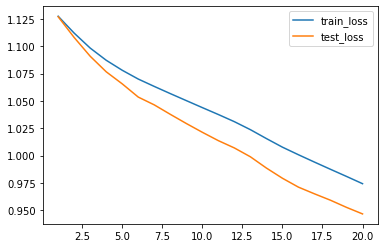

In [176]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()

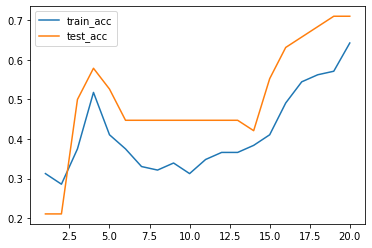

In [177]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()

## 模板代码

In [ ]:
1. 创建输入（dataloader）
2. 创建模型（model）
3  创建损失函数

编写一个fit，输入模型、输入数据（train_dl, test_dl）， 对数据输入在模型上训练，并且返回loss和acc变化

In [200]:
def fit(epoch, model, trainloader, testloader):
    correct = 0
    total = 0
    running_loss = 0
    for x, y in trainloader:
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
        
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / total
        
        
    test_correct = 0
    test_total = 0
    test_running_loss = 0 
    
    with torch.no_grad():
        for x, y in testloader:
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / test_total
    
        
    print('epoch: ', epoch, 
          'loss： ', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'test_loss： ', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3)
             )
        
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [201]:
model = Model()
optim = torch.optim.Adam(model.parameters(), lr=0.0001)

In [202]:
epochs = 20

In [203]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch,
                                                                 model,
                                                                 train_dl,
                                                                 test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss：  0.132 accuracy: 0.304 test_loss：  0.136 test_accuracy: 0.421
epoch:  1 loss：  0.131 accuracy: 0.304 test_loss：  0.135 test_accuracy: 0.421
epoch:  2 loss：  0.131 accuracy: 0.304 test_loss：  0.134 test_accuracy: 0.421
epoch:  3 loss：  0.13 accuracy: 0.304 test_loss：  0.133 test_accuracy: 0.421
epoch:  4 loss：  0.129 accuracy: 0.304 test_loss：  0.133 test_accuracy: 0.421
epoch:  5 loss：  0.129 accuracy: 0.312 test_loss：  0.132 test_accuracy: 0.421
epoch:  6 loss：  0.128 accuracy: 0.348 test_loss：  0.131 test_accuracy: 0.553
epoch:  7 loss：  0.127 accuracy: 0.446 test_loss：  0.131 test_accuracy: 0.658
epoch:  8 loss：  0.127 accuracy: 0.589 test_loss：  0.13 test_accuracy: 0.684
epoch:  9 loss：  0.126 accuracy: 0.634 test_loss：  0.129 test_accuracy: 0.684
epoch:  10 loss：  0.125 accuracy: 0.643 test_loss：  0.129 test_accuracy: 0.684
epoch:  11 loss：  0.125 accuracy: 0.652 test_loss：  0.128 test_accuracy: 0.684
epoch:  12 loss：  0.124 accuracy: 0.652 test_loss：  0.128 test_a

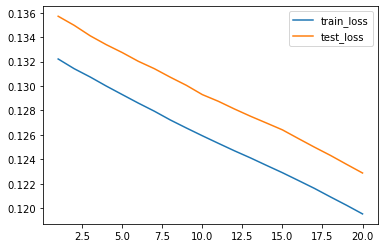

In [204]:
plt.plot(range(1, epochs+1), train_loss, label='train_loss')
plt.plot(range(1, epochs+1), test_loss, label='test_loss')
plt.legend()

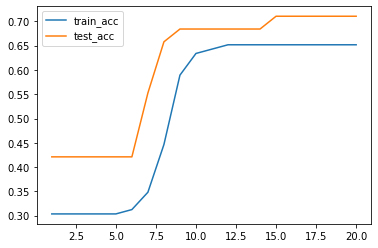

In [205]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc, label='test_acc')
plt.legend()